# EOF analysis

Contents
* [Load data](#Load-data)
* [Prepare data for EOF analysis](#Prepare-data-for-EOF-analysis)
* [Computing the EOFs and PCs](#Computing-the-EOFs-and-PCs)
* [Plotting EOFs and PCs](#Plotting-EOFs-and-PCs)

Empirical orthogonal function analysis is a data analysis technique, which is often used in atmosphere ocean science to break down a spatiotemporal signal into orthogonal modes, which are modulated in time by principal components. Suppose we have a spatiotemporal dataset, say of sea level, at points $(x,y)_i$, $i=1, \dots, m$ and times $t_j$, $j=1, \dots, n$. We can then arange the values of the dataset into an $n \times m$ matrix:

$$X = 
\begin{bmatrix}
    \eta_1(t_1) & \eta_2(t_1) & \dots & \eta_m(t_1) \\
    \eta_1(t_2) & \eta_2(t_2) & \dots & \eta_m(t_2) \\
    \vdots & & & \vdots \\
    \eta_1(t_n) & \eta_2(t_n) & \dots & \eta_m(t_n)
\end{bmatrix} 
$$

Then, we can form a covariance matrix. Let $\boldsymbol{\eta}(t_j) = (\eta_1(t_j), \dots, \eta_m(t_j)$

$$
    C = X^T X
$$

The $C_{ik}$ entry contains the product $(\eta_i(t_1), \dots, \eta_i(t_n)) \cdot (\eta_k(t_1), \dots, \eta_k(t_n))$, which removes the time dimension to give the temporal covariance between $\eta_i$ and $\eta_k$ across all times $t_1, \dots, t_n$. If $\eta_i$ and $\eta_k$ are perfectly correlated in time, the covariance is maximized; if they are completely uncorrelated, the $C_{ik}$ entry is zero.

Because the covariance matrix is symmetric, it is orthogonally diagonalizable. An easy way to get this is from the SVD of $X$. Let $X = U \Sigma V^T$. Then

$$
C = X^T X = V \Sigma U^T U \Sigma V^T = V \Sigma^2 V^T
$$

We will do this on a spatiotemporal dataset: 16 years of daily sea surface heights on a 1 degree grid in the north atlantic.

In [13]:
import numpy as np
import scipy as sc
import xarray as xr
import pandas as pd

from scipy.linalg import svd

import matplotlib.pyplot as plt

import dask
from dask.diagnostics import ProgressBar

## Load data

In [14]:
# Load data
sea_level = xr.open_dataarray('~/Tomfoolery/data/north_atlantic_picontrol_coarsened.nc')
sea_level

<xarray.DataArray (time: 5844, yt_ocean: 55, xt_ocean: 100)>
[32142000 values with dtype=float32]
Coordinates:
  * time      (time) object 0185-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 -99.5 -98.5 -97.5 -96.5 ... -3.5 -2.5 -1.5 -0.5
  * yt_ocean  (yt_ocean) float64 20.45 21.39 22.31 23.24 ... 58.7 59.21 59.72

/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'Mean sea level pattern')

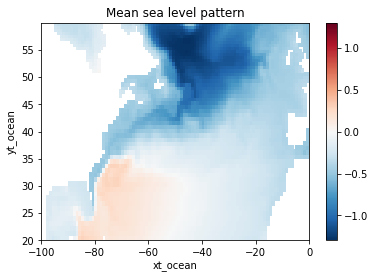

In [15]:
fig, ax = plt.subplots()
sea_level.mean(dim='time').plot(ax=ax)
ax.set_title('Mean sea level pattern')

In [16]:
# Remove seasonal cycle
gb = sea_level.groupby("time.dayofyear")
clim = gb.mean("time")
sla = gb - clim

In [17]:
time     = sla['time']
xt_ocean = sla['xt_ocean']
yt_ocean = sla['yt_ocean']

## Prepare data for EOF analysis

In [18]:
# Table of sea level values
df = sla.stack(multiindex=('yt_ocean', 'xt_ocean')).to_pandas()
df.head()

yt_ocean            20.451127                                                \
xt_ocean                -99.5 -98.5     -97.5     -96.5     -95.5     -94.5   
time                                                                          
0185-01-01 12:00:00       NaN   NaN -0.053384 -0.016279 -0.025870 -0.031436   
0185-01-02 12:00:00       NaN   NaN -0.067183 -0.029911 -0.020165 -0.024726   
0185-01-03 12:00:00       NaN   NaN -0.057970 -0.020490 -0.002467 -0.007965   
0185-01-04 12:00:00       NaN   NaN -0.014108 -0.018007 -0.018341 -0.024347   
0185-01-05 12:00:00       NaN   NaN  0.051715  0.014415 -0.029965 -0.042803   

yt_ocean                                                     ... 59.720457  \
xt_ocean                -93.5     -92.5     -91.5     -90.5  ...     -9.5    
time                                                         ...             
0185-01-01 12:00:00  0.009174  0.049064  0.082596  0.103583  ... -0.018774   
0185-01-02 12:00:00  0.013349  0.045831  0.059259  0.057044  ...  0.009065   
0185-01-03 12:00:00  0.026336  0.043997  0.045482  0.038433  ...  0.015266   
0185-01-04 12:00:00  0.010101  0.016024  0.019574  0.015642  ...  0.019868   
0185-01-05 12:00:00 -0.009302 -0.002699  0.005465  0.026174  ...  0.034134   

yt_ocean                                                               \
xt_ocean                -8.5      -7.5      -6.5      -5.5      -4.5    
time                                                                    
0185-01-01 12:00:00 -0.037156 -0.038080 -0.035511 -0.043539 -0.063808   
0185-01-02 12:00:00 -0.012481 -0.014462 -0.012277 -0.019552 -0.036984   
0185-01-03 12:00:00 -0.008322 -0.010144 -0.001875 -0.011023 -0.029389   
0185-01-04 12:00:00 -0.003490 -0.006426  0.006575  0.008833  0.000297   
0185-01-05 12:00:00  0.001917 -0.007016  0.006394  0.010728 -0.000050   

yt_ocean                                                     
xt_ocean                -3.5      -2.5      -1.5      -0.5   
time                                                         
0185-01-01 12:00:00 -0.091083 -0.101451 -0.100148 -0.120702  
0185-01-02 12:00:00 -0.071322 -0.090479 -0.108076 -0.166529  
0185-01-03 12:00:00 -0.041851 -0.062939 -0.094698 -0.155985  
0185-01-04 12:00:00 -0.010033 -0.029432 -0.060792 -0.105784  
0185-01-05 12:00:00 -0.017600 -0.029187 -0.055350 -0.094946  

[5 rows x 5500 columns]

In [19]:
# Drop columns with nans
df = df.dropna(axis=1)

# Ordered index
multiindex = df.columns

# Number of time points (N) and space points (M)
N, M = np.shape(df)
print(N, M)

5844 3976


## Computing the EOFs and PCs

In [20]:
X = df.values
U, S, Vh = svd(X)
D = sc.sparse.diags(S, shape=(N, M)) # Diagonal matrix
V = Vh.transpose()

def labelled_svd(df):
    """Computes the SVD but with pandas labels for the space and time dimension."""
    X = df.values
    N, M = np.shape(df)
    
    U, S, Vh = svd(X)
    U = xr.DataArray(U, 
        dims=('time', 'index'),
        coords = {
            'time' : df.index,
            'index': np.arange(1, N+1)
        }
    )
    
    D = sc.sparse.diags(S, shape=(N, M))
    
    V = Vh.transpose()
    V = xr.DataArray(V, 
        dims=('loc', 'index'),
        coords = {
            'loc' : df.columns,
            'index': np.arange(1, M+1)
        }
    )
    return U, D, V

In [21]:
def get_PC(U, k):
    """
    Returns the kth PC (indexed starting from 1).
    """
    return U[:, k-1]

def get_EOF(V, k): 
    """
    Returns the kth EOF (indexed starting from 1).
    Not normalized by singular value.
    """
    return V[:, k-1]

def normalized_singular_vals(S):
    """
    Computes the singular values, normalized by norm of S.
    """
    return S / sc.linalg.norm(S)

get_PC(U, 2)

array([ 0.00400582,  0.00395453,  0.00231788, ..., -0.00257875,
       -0.00487489, -0.003874  ], dtype=float32)

## Plotting EOFs and PCs

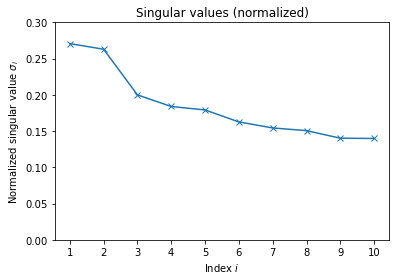

In [22]:
# List of singular values to plot
ns = np.arange(1, 11)

# Weight singular values by norm of singular values
svs = normalized_singular_vals(S)

## Plot of normalized singular values
fig, ax = plt.subplots()
ax.plot(ns, svs[0:10], ls='-', marker='x')

ax.set(
    title='Singular values (normalized)',
    xlabel=r'Index $i$',
    ylabel=r'Normalized singular value $\sigma_i$',
    ylim=(0,0.3),
    xticks=ns
);

In [23]:
def plot_PC(U, k, ax):
    PC = get_PC(U, k)
    ax.plot(time, PC)
    ax.set(
        title='Principal component ' + str(k),
        xlabel='time [year]',
        ylabel='PC'
    )
    ax.set_title('Principal component ' + str(k))
    
def plot_EOF(V, k, ax):
    EOF = get_EOF(V, k)
    EOF = pd.Series(EOF, index=multiindex)
    
    # Convert to DataArray
    darray = EOF.to_xarray()
    ### Coords need to be in ascending order to be plotted
    darray = darray.sortby('yt_ocean').sortby('xt_ocean')
    darray = darray.rename('EOF ' + str(k))
    
    # Plot dataarray
    darray.plot(ax=ax)
    ax.set_title('EOF ' + str(k))

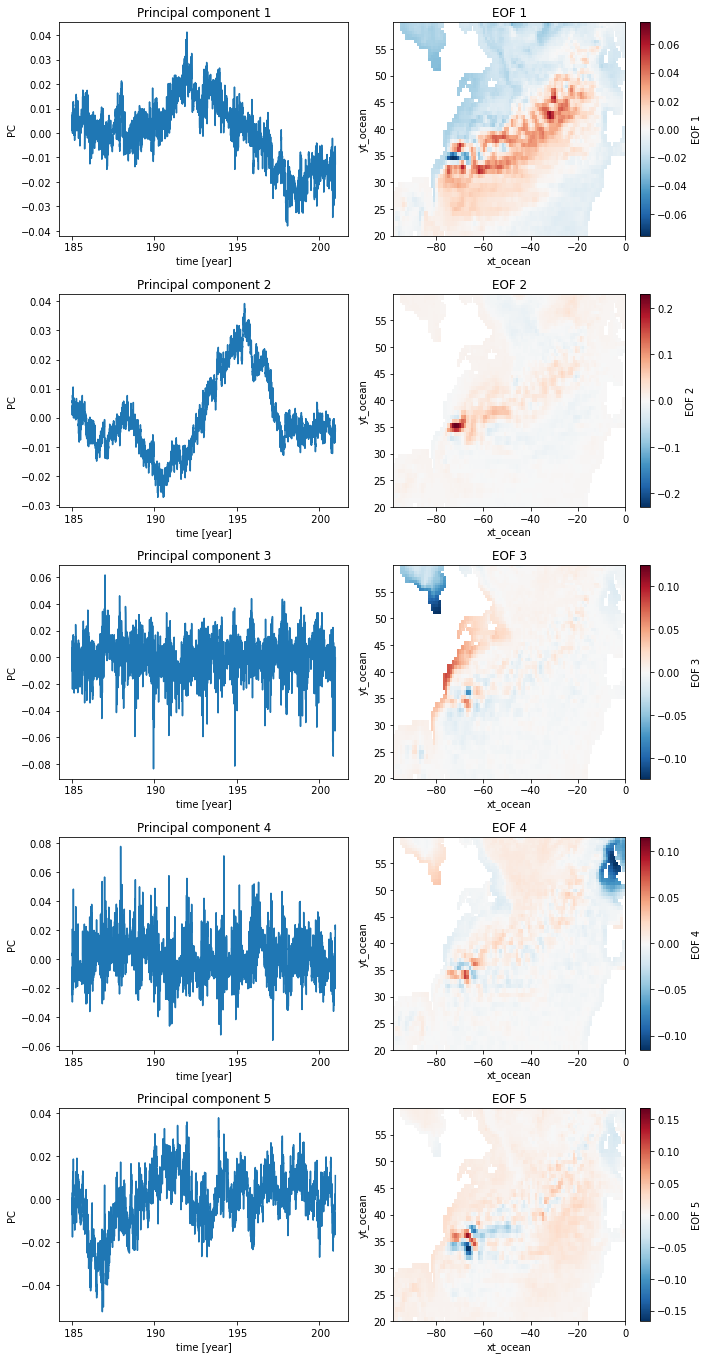

In [24]:
components=5

fig, ax = plt.subplots(figsize=(10, 3+4*(components-1)), ncols=2, nrows=components)
for i in range(0, components):
    plot_PC(U, i+1, ax[i, 0])
    
    plot_EOF(V, i+1, ax[i, 1])
    
plt.tight_layout()